In [100]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from catboost import CatBoostClassifier
import lightgbm as lgb
#from pandas_profiling import ProfileReport

# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [101]:
# Load our dataset
data = pd.read_csv("/kaggle/input/ecommerce-product-recommendation-collaborative/user_personalized_features.csv")
df_train = data.copy() # for supervised 

In [102]:
# have a look on data
data.head()

Unnamed: 0 User_ID  Age  Gender  Location  Income   Interests  \
0           0      #1   56    Male  Suburban   38037      Sports   
1           1      #2   46  Female     Rural  103986  Technology   
2           2      #3   32  Female  Suburban  101942      Sports   
3           3      #4   60  Female  Suburban   71612     Fashion   
4           4      #5   25    Male  Suburban   49725      Travel   

   Last_Login_Days_Ago  Purchase_Frequency  Average_Order_Value  \
0                    5                   7                   18   
1                   15                   7                  118   
2                   28                   1                  146   
3                   18                   3                  163   
4                    2                   5                  141   

   Total_Spending Product_Category_Preference  Time_Spent_on_Site_Minutes  \
0            2546                       Books                         584   
1             320                 Electronics                         432   
2            3766                     Apparel                         306   
3            4377                     Apparel                         527   
4            4502             Health & Beauty                          53   

   Pages_Viewed  Newsletter_Subscription  
0            38                     True  
1            40                    False  
2             1                     True  
3            29                    False  
4            10                     True

In [103]:
# shape of data
data.shape

(1000, 15)

# EDA

In [104]:
# null values in data
data.isnull().sum()

Unnamed: 0                     0
User_ID                        0
Age                            0
Gender                         0
Location                       0
Income                         0
Interests                      0
Last_Login_Days_Ago            0
Purchase_Frequency             0
Average_Order_Value            0
Total_Spending                 0
Product_Category_Preference    0
Time_Spent_on_Site_Minutes     0
Pages_Viewed                   0
Newsletter_Subscription        0
dtype: int64

So, there are no null values or missing values in our dataset and that's good for us.

In [105]:
# duplicate rows
data.duplicated().sum()

0

No duplicates, that's pretty cool.

In [106]:
# Drop the unnecessary columns "Unnamed: 0" and "User_ID"
data.drop(['Unnamed: 0','User_ID'], axis=1, inplace=True)

In [107]:
# Display the first few rows to verify the changes
data.head()

Age  Gender  Location  Income   Interests  Last_Login_Days_Ago  \
0   56    Male  Suburban   38037      Sports                    5   
1   46  Female     Rural  103986  Technology                   15   
2   32  Female  Suburban  101942      Sports                   28   
3   60  Female  Suburban   71612     Fashion                   18   
4   25    Male  Suburban   49725      Travel                    2   

   Purchase_Frequency  Average_Order_Value  Total_Spending  \
0                   7                   18            2546   
1                   7                  118             320   
2                   1                  146            3766   
3                   3                  163            4377   
4                   5                  141            4502   

  Product_Category_Preference  Time_Spent_on_Site_Minutes  Pages_Viewed  \
0                       Books                         584            38   
1                 Electronics                         432            40   
2                     Apparel                         306             1   
3                     Apparel                         527            29   
4             Health & Beauty                          53            10   

   Newsletter_Subscription  
0                     True  
1                    False  
2                     True  
3                    False  
4                     True

Now, its looking good.

In [108]:
# let's have a look on the cardinality of each feature
data.nunique()

Age                             47
Gender                           2
Location                         3
Income                         996
Interests                        5
Last_Login_Days_Ago             29
Purchase_Frequency              10
Average_Order_Value            189
Total_Spending                 908
Product_Category_Preference      5
Time_Spent_on_Site_Minutes     491
Pages_Viewed                    49
Newsletter_Subscription          2
dtype: int64

In [109]:
# let's have a look on data type of each feature
data.dtypes

Age                             int64
Gender                         object
Location                       object
Income                          int64
Interests                      object
Last_Login_Days_Ago             int64
Purchase_Frequency              int64
Average_Order_Value             int64
Total_Spending                  int64
Product_Category_Preference    object
Time_Spent_on_Site_Minutes      int64
Pages_Viewed                    int64
Newsletter_Subscription          bool
dtype: object

In [110]:
# get some statistical info about our data
data.describe()

Age         Income  Last_Login_Days_Ago  Purchase_Frequency  \
count  1000.000000    1000.000000          1000.000000         1000.000000   
mean     40.986000   81304.732000            15.586000            4.631000   
std      13.497852   37363.972753             8.205604            2.837762   
min      18.000000   20155.000000             1.000000            0.000000   
25%      29.000000   48715.500000             8.000000            2.000000   
50%      42.000000   81042.000000            16.000000            5.000000   
75%      52.000000  112694.500000            23.000000            7.000000   
max      64.000000  149951.000000            29.000000            9.000000   

       Average_Order_Value  Total_Spending  Time_Spent_on_Site_Minutes  \
count          1000.000000     1000.000000                 1000.000000   
mean            104.039000     2552.957000                  297.360000   
std              54.873569     1420.985048                  175.596123   
min              10.000000      112.000000                    2.000000   
25%              58.000000     1271.750000                  144.000000   
50%             105.000000     2542.000000                  292.500000   
75%             150.000000     3835.500000                  449.250000   
max             199.000000     4999.000000                  599.000000   

       Pages_Viewed  
count    1000.00000  
mean       24.40300  
std        14.02017  
min         1.00000  
25%        12.00000  
50%        24.50000  
75%        36.00000  
max        49.00000

#### Age
- Average Age: 41 years
- Youngest User: 18 years
- Oldest User: 64 years
- Typical Age Range: Most users are between 29 and 52 years old.

#### Income
- Average Income: 81,304 dollars per year
- Lowest Income: 20,155 dollars per year
- Highest Income: 149,951 dollars per year
- Typical Income Range: Most users earn between 48,716 dollars and 112,695 dollars per year.


#### Last Login Days Ago
- Average Days Since Last Login: 16 days
- Shortest Time Since Last Login: 1 day
- Longest Time Since Last Login: 29 days
- Typical Time Since Last Login: Most users last logged in between 8 and 23 days ago.

#### Purchase Frequency
- Average Purchases: 5 purchases
- Least Purchases: 0 purchases
- Most Purchases: 9 purchases
- Typical Purchase Frequency: Most users make between 2 and 7 purchases.

#### Average Order Value
- Average Order Value: 104 dollars
- Lowest Order Value: 10 dollars
- Highest Order Value: 199 dollars
- Typical Order Value Range: Most orders are between 58 dollars and 150 dollars.

#### Total Spending
- Average Total Spending: 2,553 dollars
- Lowest Total Spending: 112 dollars
- Highest Total Spending: 4,999 dollars
- Typical Total Spending Range: Most users spend between 1,272 dollars and 3,836 dollars in total.

#### Time Spent on Site
- Average Time Spent: 297 minutes (almost 5 hours)
- Least Time Spent: 2 minutes
- Most Time Spent: 599 minutes (almost 10 hours)
- Typical Time Spent Range: Most users spend between 144 and 449 minutes.

#### Pages Viewed
- Average Pages Viewed: 24 pages
- Fewest Pages Viewed: 1 page
- Most Pages Viewed: 49 pages
- Typical Pages Viewed Range: Most users view between 12 and 36 pages.

In [111]:
# Function for univariate analysis
def plot_univariate(df, columns):
    sns.set_theme(style="dark")
    num_plots = len(columns)
    cols = 3
    rows = math.ceil(num_plots / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
    axes = axes.flatten()
    
    for i, column in enumerate(columns):
        if df[column].dtype == 'object':
            sns.countplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(f'Count Plot for {column}')
        else:
            sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histogram for {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
    
    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

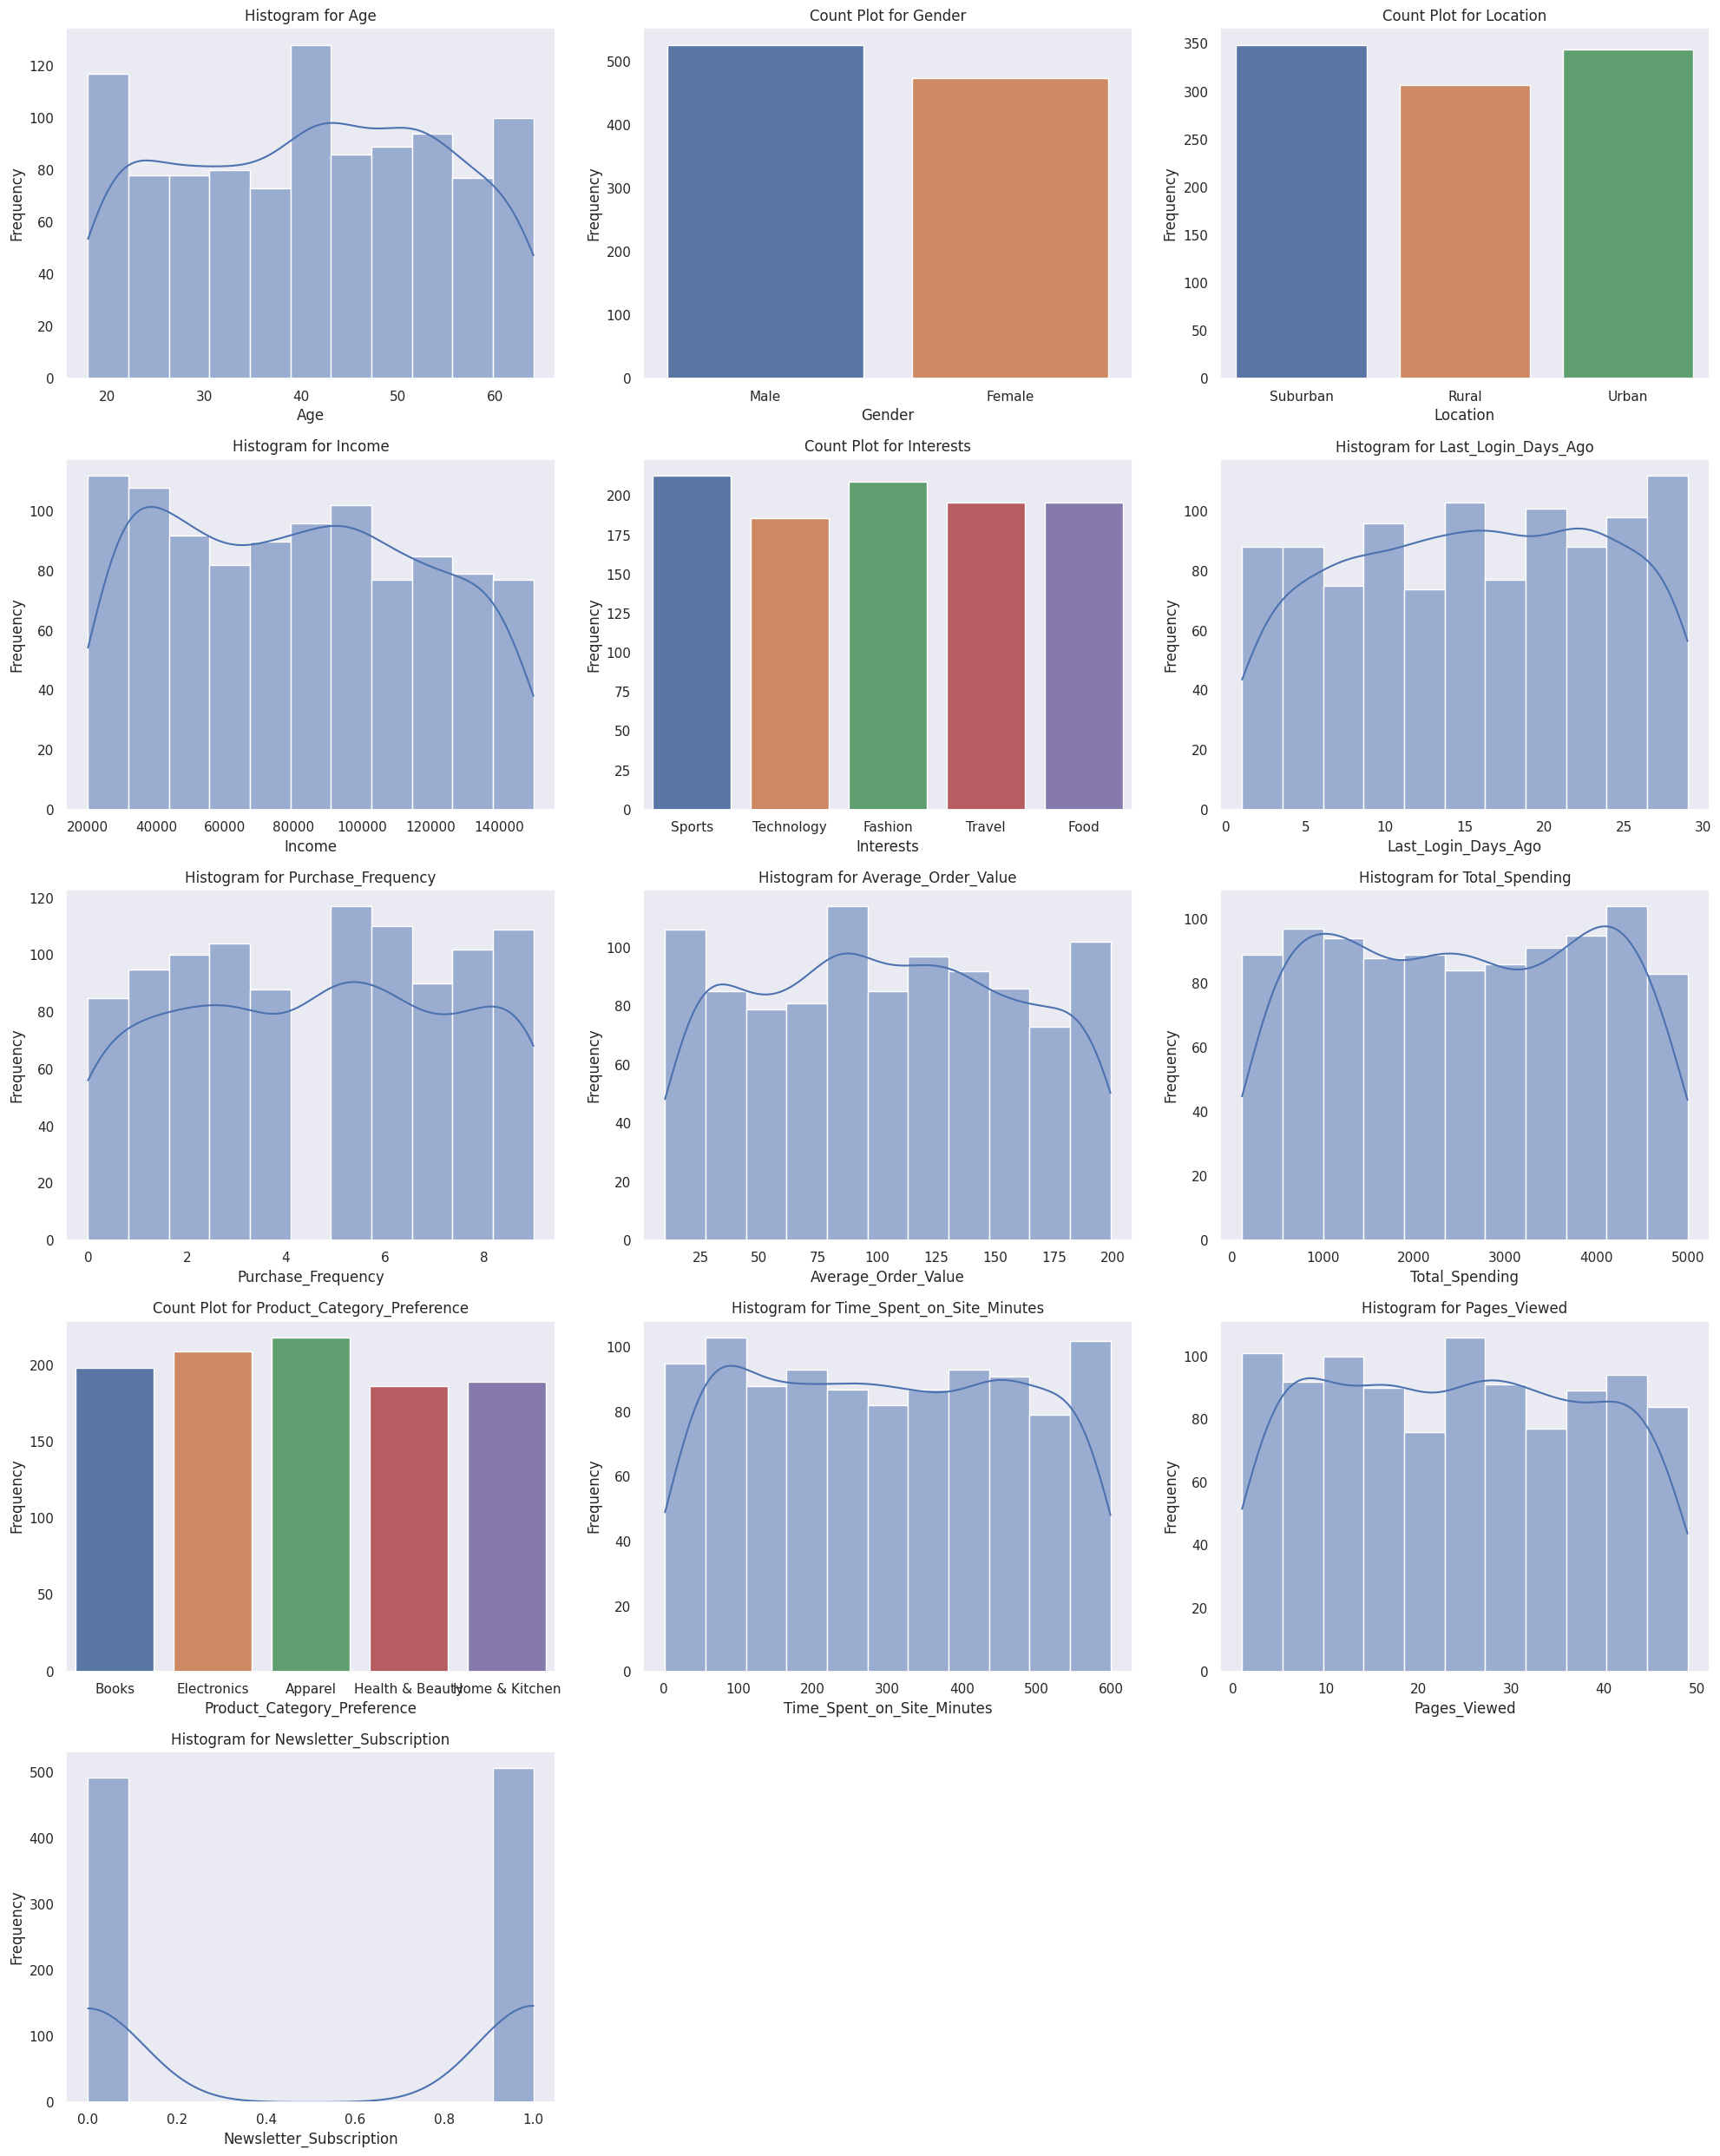

In [112]:
# Apply univariate analysis to all columns
univariate_columns = data.columns
plot_univariate(data, univariate_columns)

From the above plots, it is clear that-
- Number of female is slightly lesser than male.
- Number of users in Rural locations are slightly lesser than in Urban and Semiurban areas.

In [113]:
# Function for bivariate analysis
def plot_bivariate(df, column_pairs):
    num_plots = len(column_pairs)
    cols = 3
    rows = math.ceil(num_plots / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
    axes = axes.flatten()
    
    for i, (column1, column2) in enumerate(column_pairs):
        if df[column1].dtype == 'object' and df[column2].dtype == 'object':
            sns.countplot(data=df, x=column1, hue=column2, ax=axes[i], palette='coolwarm')
            axes[i].set_title(f'Count Plot for {column1} vs {column2}', fontsize=14)
        elif df[column1].dtype != 'object' and df[column2].dtype != 'object':
            sns.scatterplot(data=df, x=column1, y=column2, ax=axes[i])
            axes[i].set_title(f'Scatter Plot for {column1} vs {column2}', fontsize=14)
        else:
            sns.boxplot(data=df, x=column1, y=column2, ax=axes[i])
            axes[i].set_title(f'Box Plot for {column1} vs {column2}', fontsize=14)
        axes[i].set_xlabel(column1, fontsize=12)
        axes[i].set_ylabel(column2, fontsize=12)
    
    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

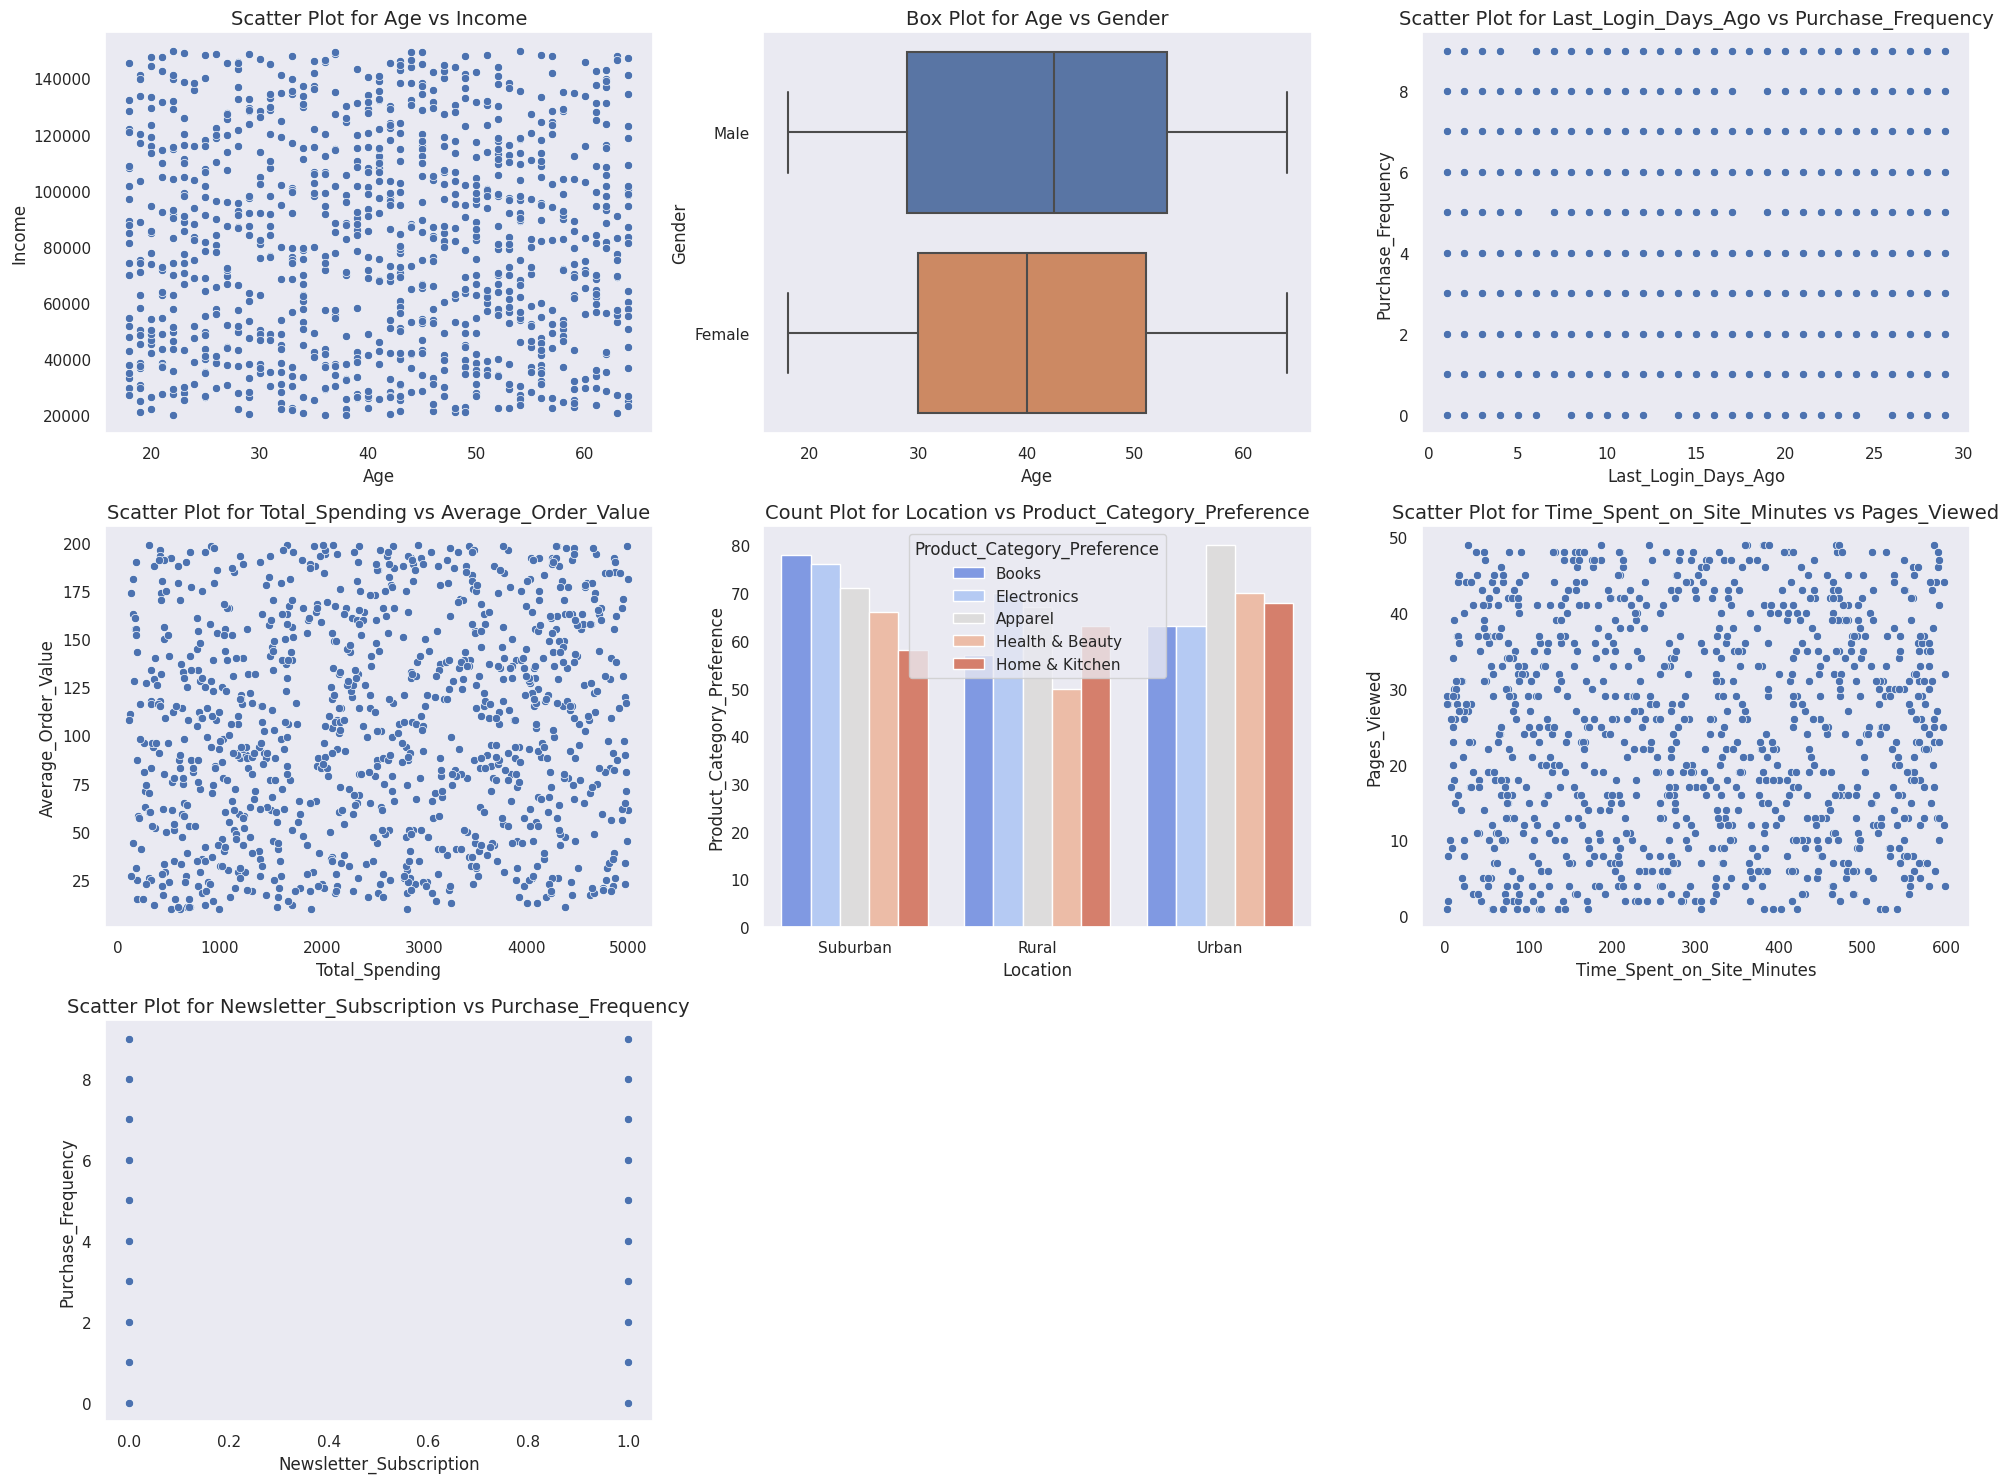

In [114]:
# Define column pairs for bivariate analysis
bivariate_columns_to_pair = [
    ('Age', 'Income'),
    ('Age', 'Gender'),
    ('Last_Login_Days_Ago', 'Purchase_Frequency'),
    ('Total_Spending', 'Average_Order_Value'),
    ('Location', 'Product_Category_Preference'),
    ('Time_Spent_on_Site_Minutes', 'Pages_Viewed'),
    ('Newsletter_Subscription', 'Purchase_Frequency')
]

# Apply bivariate analysis to adjusted column pairs
plot_bivariate(data, bivariate_columns_to_pair)

It seems like, no two features are related. 

In [115]:
# all column names
data.columns

Index(['Age', 'Gender', 'Location', 'Income', 'Interests',
       'Last_Login_Days_Ago', 'Purchase_Frequency', 'Average_Order_Value',
       'Total_Spending', 'Product_Category_Preference',
       'Time_Spent_on_Site_Minutes', 'Pages_Viewed',
       'Newsletter_Subscription'],
      dtype='object')

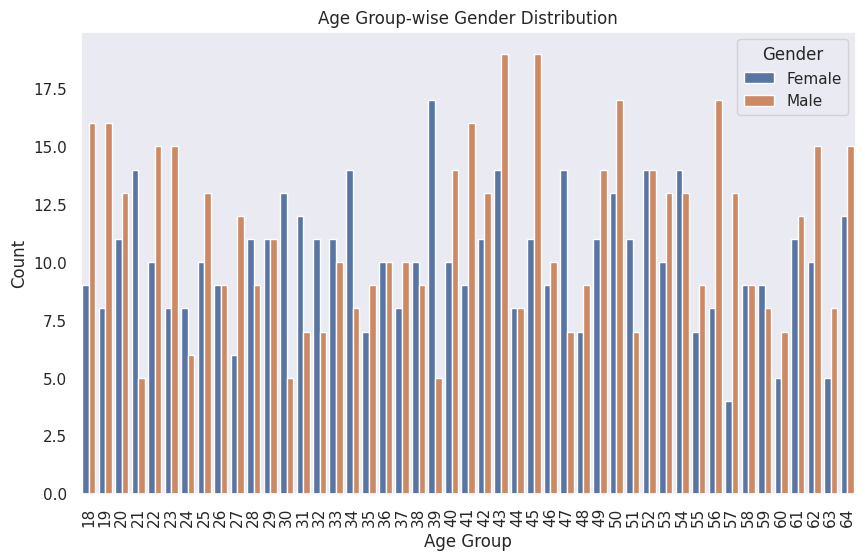

In [116]:
# Grouping by Age and Gender, and counting occurrences
grouped_age_gender = data.groupby(['Age', 'Gender']).size().reset_index(name='Count')

# Plotting using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Age', y='Count', hue='Gender', data=grouped_age_gender)
plt.title('Age Group-wise Gender Distribution')
plt.xticks(rotation="vertical")
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

For most of the Age groups, number of females are less than or equal to number of males, but there are some in which number of females is greater than number of males.

In [117]:
data['Gender'].value_counts()

Gender
Male      526
Female    474
Name: count, dtype: int64

Blanced!

In [118]:
data['Location'].value_counts()

Location
Suburban    349
Urban       344
Rural       307
Name: count, dtype: int64

Balanced!

In [119]:
data['Interests'].value_counts()

Interests
Sports        213
Fashion       209
Travel        196
Food          196
Technology    186
Name: count, dtype: int64

Balanced!

In [120]:
data['Purchase_Frequency'].value_counts()

Purchase_Frequency
5    117
6    110
9    109
3    104
8    102
2    100
1     95
7     90
4     88
0     85
Name: count, dtype: int64

Almost Balanced!

In [121]:
data['Product_Category_Preference'].value_counts()

Product_Category_Preference
Apparel            218
Electronics        209
Books              198
Home & Kitchen     189
Health & Beauty    186
Name: count, dtype: int64

Balanced!

In [122]:
data['Newsletter_Subscription'].value_counts()

Newsletter_Subscription
True     507
False    493
Name: count, dtype: int64

Balanced!

Well, i were checking, if there is some imbalancements, but the features are balanced for each category.

## Feature Engineering

In [123]:
#data["User_ID"] = data['User_ID'].str.replace('#', '').astype(int)

In [124]:
data.head()

Age  Gender  Location  Income   Interests  Last_Login_Days_Ago  \
0   56    Male  Suburban   38037      Sports                    5   
1   46  Female     Rural  103986  Technology                   15   
2   32  Female  Suburban  101942      Sports                   28   
3   60  Female  Suburban   71612     Fashion                   18   
4   25    Male  Suburban   49725      Travel                    2   

   Purchase_Frequency  Average_Order_Value  Total_Spending  \
0                   7                   18            2546   
1                   7                  118             320   
2                   1                  146            3766   
3                   3                  163            4377   
4                   5                  141            4502   

  Product_Category_Preference  Time_Spent_on_Site_Minutes  Pages_Viewed  \
0                       Books                         584            38   
1                 Electronics                         432            40   
2                     Apparel                         306             1   
3                     Apparel                         527            29   
4             Health & Beauty                          53            10   

   Newsletter_Subscription  
0                     True  
1                    False  
2                     True  
3                    False  
4                     True

In [125]:
# Define categorical and numerical features
categorical_features = ['Gender', 'Location', 'Interests', 'Product_Category_Preference']
numerical_features = ['Age', 'Last_Login_Days_Ago', 'Purchase_Frequency', 'Average_Order_Value',
                      'Total_Spending', 'Time_Spent_on_Site_Minutes', 'Pages_Viewed', 'Income']

In [126]:
# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['Gender', 'Location', 'Interests', 'Product_Category_Preference']

In [127]:
# Replace Male as 1 and female as 0.
data['Gender'] = data['Gender'].replace({'Male':1, 'Female':0})
data['Gender'][:5]

0    1
1    0
2    0
3    0
4    1
Name: Gender, dtype: int64

In [128]:
# Replace Suburban as 1, Urban as 2, Rural as 0
data['Location'] = data['Location'].replace({'Suburban':1, 'Urban':2, 'Rural':0})
data['Location'][:10]

0    1
1    0
2    1
3    1
4    1
5    1
6    2
7    2
8    0
9    2
Name: Location, dtype: int64

In [129]:
# Replace Sports as 0, Fashion as 1, Travel as 2, Food as 3, Technology as 4.
data['Interests'] = data['Interests'].replace({'Sports':0, 'Fashion':1, 'Travel':2, 'Food':3, 'Technology':4})
data['Interests'][:5]

0    0
1    4
2    0
3    1
4    2
Name: Interests, dtype: int64

In [130]:
# Replace Apparel as 0, Electronics as 1, Books as 2, Home & Kitchen as 3, Health & Beauty as 4.
data['Product_Category_Preference'] = data['Product_Category_Preference'].replace({'Apparel':0, 'Electronics':1, 'Books':2, 'Home & Kitchen':3, 'Health & Beauty':4})
data['Product_Category_Preference'][:10]

0    2
1    1
2    0
3    0
4    4
5    2
6    3
7    0
8    2
9    1
Name: Product_Category_Preference, dtype: int64

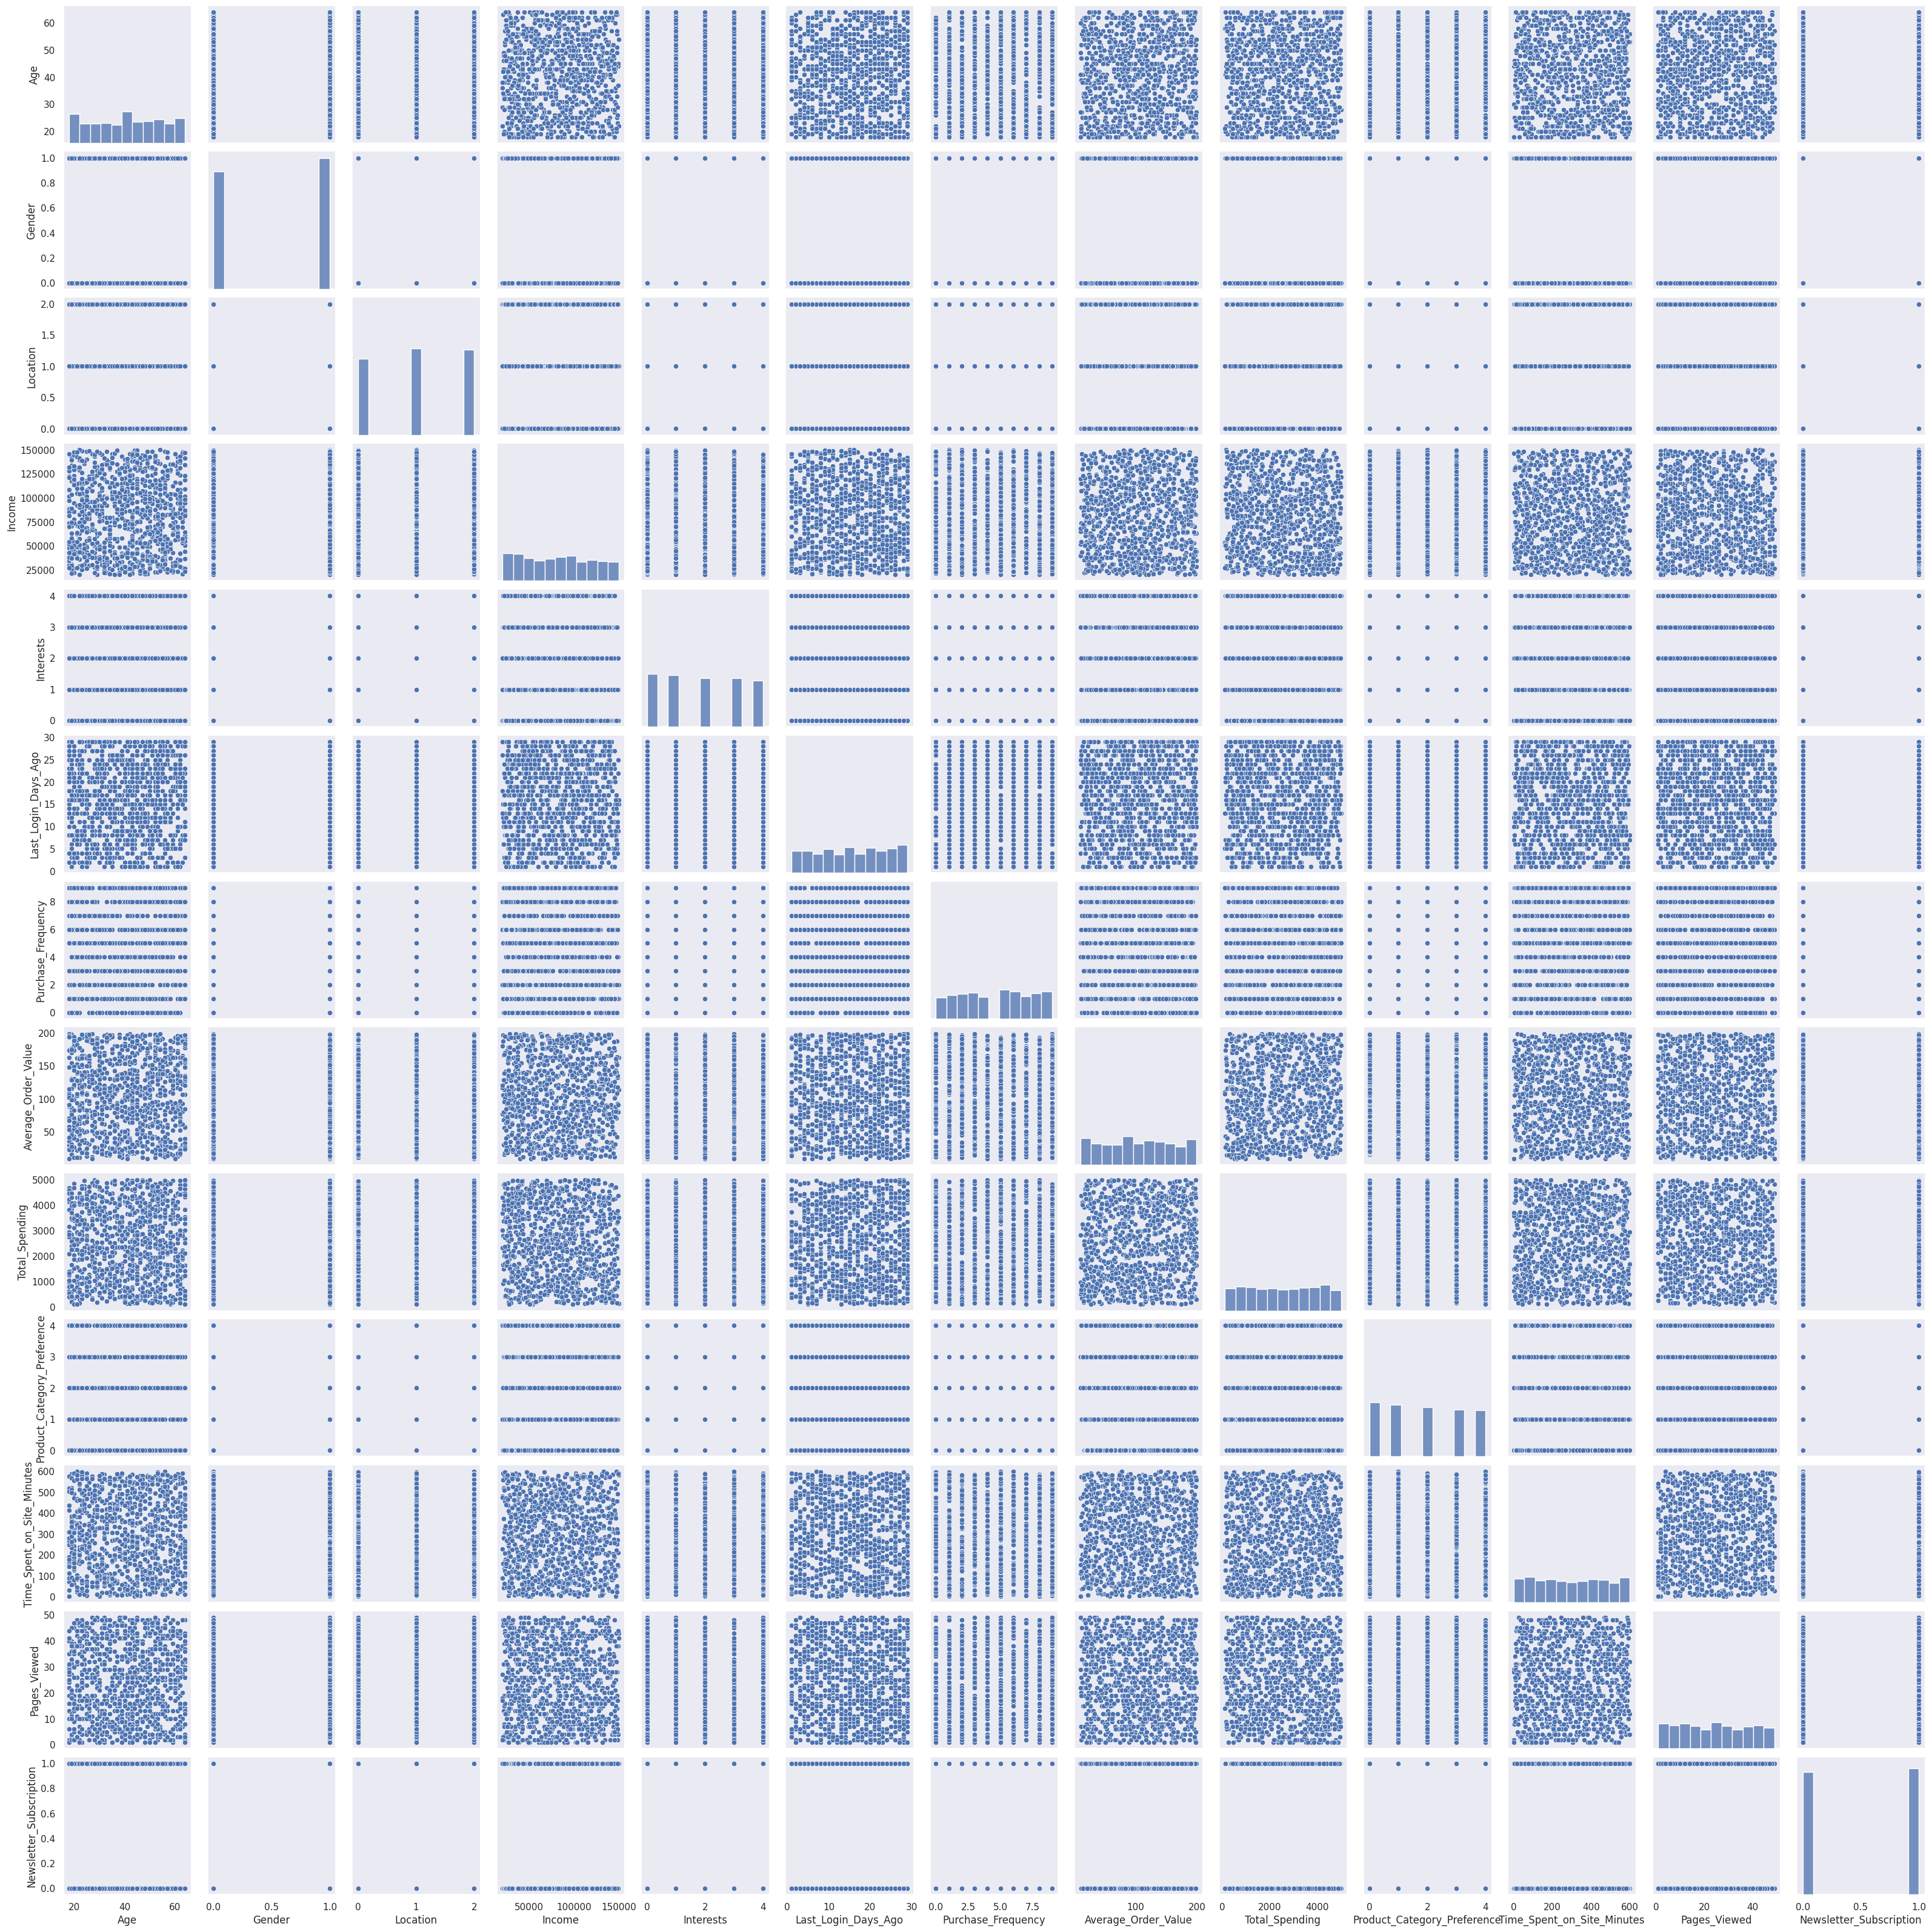

In [131]:
sns.pairplot(data)  # Pairplot for visualizing relationships
plt.show()

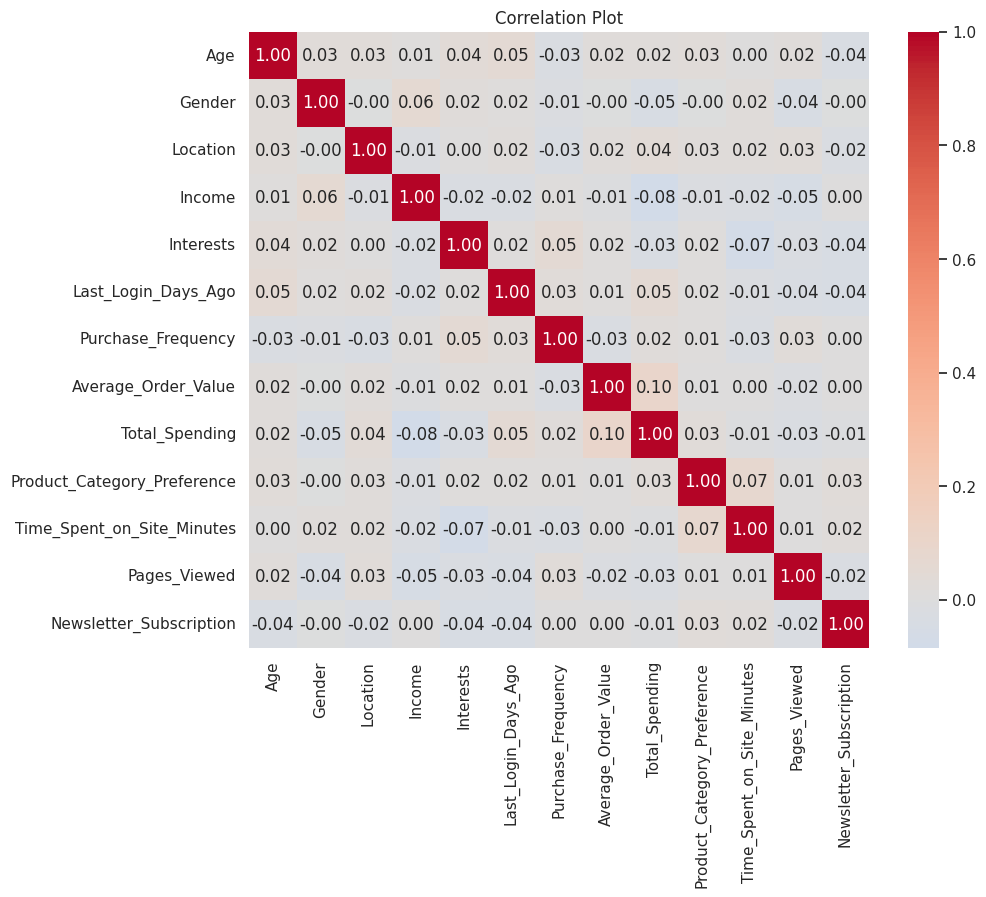

In [132]:
# Calculate correlation matrix
corr_matrix = data.corr()

# Plotting correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Plot')
plt.show()

Well, as we have seen above, no correlations.

In [133]:
# Standardizing numerical features to have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [134]:
data.head()

Age  Gender  Location    Income  Interests  Last_Login_Days_Ago  \
0  1.112882       1         1 -1.158586          0            -1.290739   
1  0.371652       0         0  0.607340          4            -0.071450   
2 -0.666069       0         1  0.552607          0             1.513626   
3  1.409373       0         1 -0.259544          1             0.294336   
4 -1.184929       1         1 -0.845615          2            -1.656526   

   Purchase_Frequency  Average_Order_Value  Total_Spending  \
0            0.835231            -1.568734       -0.004898   
1            0.835231             0.254549       -1.572201   
2           -1.280170             0.765068        0.854091   
3           -0.575036             1.075026        1.284289   
4            0.130097             0.673904        1.372300   

   Product_Category_Preference  Time_Spent_on_Site_Minutes  Pages_Viewed  \
0                            2                    1.633199      0.970302   
1                            1                    0.767143      1.113025   
2                            0                    0.049228     -1.670073   
3                            0                    1.308428      0.328049   
4                            4                   -1.392299     -1.027820   

   Newsletter_Subscription  
0                     True  
1                    False  
2                     True  
3                    False  
4                     True

In [135]:
# true as 1 and false as 0
data['Newsletter_Subscription'] = data['Newsletter_Subscription'].astype(int)

In [136]:
data.head()

Age  Gender  Location    Income  Interests  Last_Login_Days_Ago  \
0  1.112882       1         1 -1.158586          0            -1.290739   
1  0.371652       0         0  0.607340          4            -0.071450   
2 -0.666069       0         1  0.552607          0             1.513626   
3  1.409373       0         1 -0.259544          1             0.294336   
4 -1.184929       1         1 -0.845615          2            -1.656526   

   Purchase_Frequency  Average_Order_Value  Total_Spending  \
0            0.835231            -1.568734       -0.004898   
1            0.835231             0.254549       -1.572201   
2           -1.280170             0.765068        0.854091   
3           -0.575036             1.075026        1.284289   
4            0.130097             0.673904        1.372300   

   Product_Category_Preference  Time_Spent_on_Site_Minutes  Pages_Viewed  \
0                            2                    1.633199      0.970302   
1                            1                    0.767143      1.113025   
2                            0                    0.049228     -1.670073   
3                            0                    1.308428      0.328049   
4                            4                   -1.392299     -1.027820   

   Newsletter_Subscription  
0                        1  
1                        0  
2                        1  
3                        0  
4                        1

In [137]:
#data.drop(['User_ID'], inplace=True, axis=1)

## Clustering

In [138]:
# Applying Principal Component Analysis (PCA) to reduce the dimensionality of the dataset to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data)

In [139]:
pca_components

array([[-1.18133821, -1.68939102],
       [ 0.73150484,  2.11265652],
       [-2.7325563 , -0.17520518],
       ...,
       [ 1.43958579,  1.49126185],
       [-0.62400844,  0.60920037],
       [ 0.13462548, -2.88757574]])

### Elbow Method

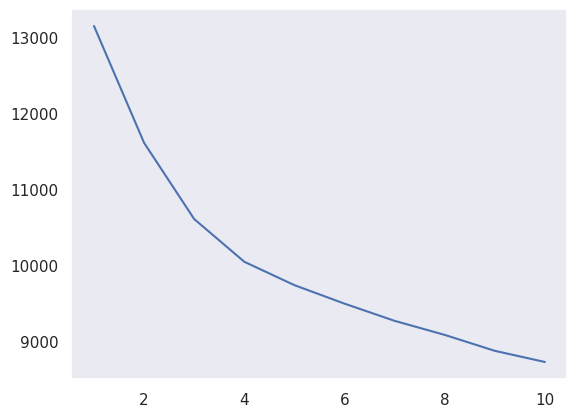

In [140]:
# wcss sum
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_init = 10, n_clusters = i, random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11),wcss)

So the optimal number of clusters may be 3 or 4.

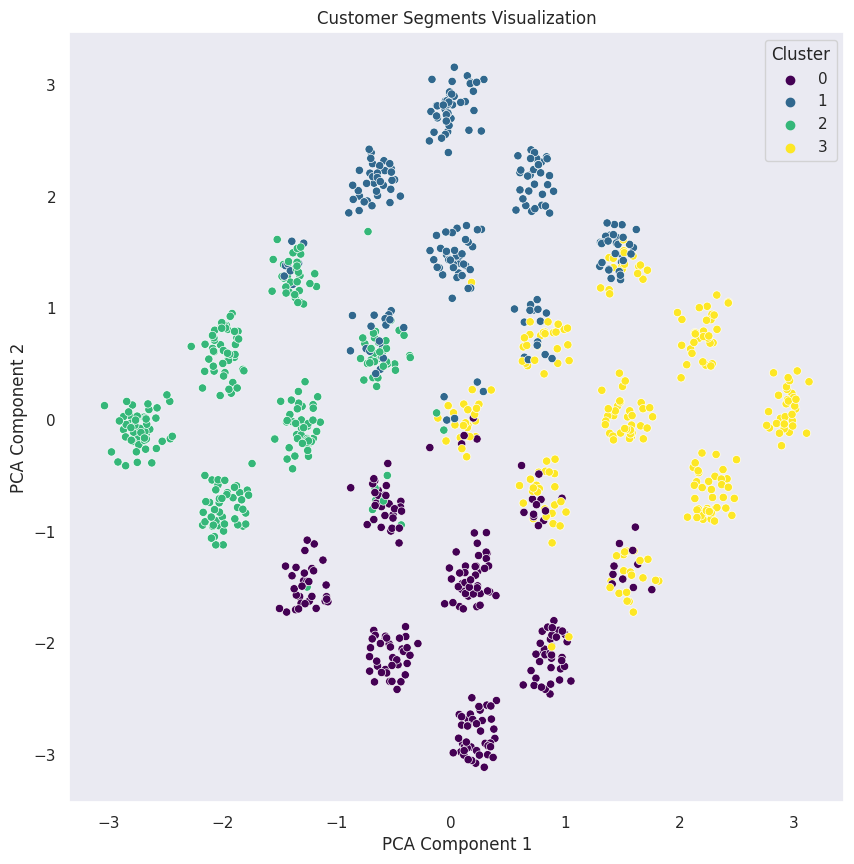

In [141]:
# fit kmeans and visualize clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)
data['Cluster'] = kmeans.fit_predict(data)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=data['Cluster'], palette='viridis')
plt.title('Customer Segments Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

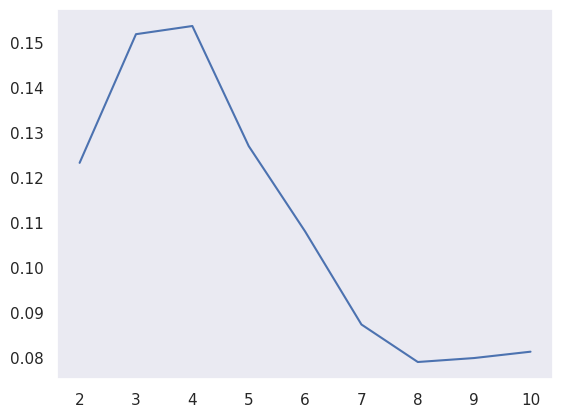

In [142]:
# silhouete score curve
sil = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    sil.append(silhouette_avg)
    
plt.plot(range(2,11),sil)

In [143]:
data.head()

Age  Gender  Location    Income  Interests  Last_Login_Days_Ago  \
0  1.112882       1         1 -1.158586          0            -1.290739   
1  0.371652       0         0  0.607340          4            -0.071450   
2 -0.666069       0         1  0.552607          0             1.513626   
3  1.409373       0         1 -0.259544          1             0.294336   
4 -1.184929       1         1 -0.845615          2            -1.656526   

   Purchase_Frequency  Average_Order_Value  Total_Spending  \
0            0.835231            -1.568734       -0.004898   
1            0.835231             0.254549       -1.572201   
2           -1.280170             0.765068        0.854091   
3           -0.575036             1.075026        1.284289   
4            0.130097             0.673904        1.372300   

   Product_Category_Preference  Time_Spent_on_Site_Minutes  Pages_Viewed  \
0                            2                    1.633199      0.970302   
1                            1                    0.767143      1.113025   
2                            0                    0.049228     -1.670073   
3                            0                    1.308428      0.328049   
4                            4                   -1.392299     -1.027820   

   Newsletter_Subscription  Cluster  
0                        1        0  
1                        0        1  
2                        1        2  
3                        0        2  
4                        1        3

In [144]:
# Most Preferred Product Category for Each Cluster
data['Product_Category_Preference'] = data['Product_Category_Preference'].replace({0:'Apparel', 1:'Electronics', 2:'Books', 3:'Home & Kitchen', 4:'Health & Beauty'})

preferred_product_category_per_cluster = data.groupby('Cluster')['Product_Category_Preference'].agg(lambda x: x.value_counts().idxmax())

print("Most Preferred Product Category for Each Cluster:")
print(preferred_product_category_per_cluster)

Most Preferred Product Category for Each Cluster:
Cluster
0     Home & Kitchen
1        Electronics
2            Apparel
3    Health & Beauty
Name: Product_Category_Preference, dtype: object


### Now, I will take newspaper subscription as my output feature, so this will be a classification probelm. 

In [145]:
df_train.head()

Unnamed: 0 User_ID  Age  Gender  Location  Income   Interests  \
0           0      #1   56    Male  Suburban   38037      Sports   
1           1      #2   46  Female     Rural  103986  Technology   
2           2      #3   32  Female  Suburban  101942      Sports   
3           3      #4   60  Female  Suburban   71612     Fashion   
4           4      #5   25    Male  Suburban   49725      Travel   

   Last_Login_Days_Ago  Purchase_Frequency  Average_Order_Value  \
0                    5                   7                   18   
1                   15                   7                  118   
2                   28                   1                  146   
3                   18                   3                  163   
4                    2                   5                  141   

   Total_Spending Product_Category_Preference  Time_Spent_on_Site_Minutes  \
0            2546                       Books                         584   
1             320                 Electronics                         432   
2            3766                     Apparel                         306   
3            4377                     Apparel                         527   
4            4502             Health & Beauty                          53   

   Pages_Viewed  Newsletter_Subscription  
0            38                     True  
1            40                    False  
2             1                     True  
3            29                    False  
4            10                     True

In [146]:
# Drop the unnecessary columns "Unnamed: 0" and "User_ID"
df_train.drop(['Unnamed: 0','User_ID'], axis=1, inplace=True)

In [147]:
# Replace Male as 1 and female as 0.
df_train['Gender'] = df_train['Gender'].replace({'Male':1, 'Female':0})

In [148]:
# Replace Suburban as 1, Urban as 2, Rural as 0
df_train['Location'] = df_train['Location'].replace({'Suburban':1, 'Urban':2, 'Rural':0})

In [149]:
# Replace Sports as 0, Fashion as 1, Travel as 2, Food as 3, Technology as 4.
df_train['Interests'] = df_train['Interests'].replace({'Sports':0, 'Fashion':1, 'Travel':2, 'Food':3, 'Technology':4})

In [150]:
# Replace Apparel as 0, Electronics as 1, Books as 2, Home & Kitchen as 3, Health & Beauty as 4.
df_train['Product_Category_Preference'] = df_train['Product_Category_Preference'].replace({'Apparel':0, 'Electronics':1, 'Books':2, 'Home & Kitchen':3, 'Health & Beauty':4})

In [151]:
df_train.head()

Age  Gender  Location  Income  Interests  Last_Login_Days_Ago  \
0   56       1         1   38037          0                    5   
1   46       0         0  103986          4                   15   
2   32       0         1  101942          0                   28   
3   60       0         1   71612          1                   18   
4   25       1         1   49725          2                    2   

   Purchase_Frequency  Average_Order_Value  Total_Spending  \
0                   7                   18            2546   
1                   7                  118             320   
2                   1                  146            3766   
3                   3                  163            4377   
4                   5                  141            4502   

   Product_Category_Preference  Time_Spent_on_Site_Minutes  Pages_Viewed  \
0                            2                         584            38   
1                            1                         432            40   
2                            0                         306             1   
3                            0                         527            29   
4                            4                          53            10   

   Newsletter_Subscription  
0                     True  
1                    False  
2                     True  
3                    False  
4                     True

In [152]:
df_train.dtypes

Age                            int64
Gender                         int64
Location                       int64
Income                         int64
Interests                      int64
Last_Login_Days_Ago            int64
Purchase_Frequency             int64
Average_Order_Value            int64
Total_Spending                 int64
Product_Category_Preference    int64
Time_Spent_on_Site_Minutes     int64
Pages_Viewed                   int64
Newsletter_Subscription         bool
dtype: object

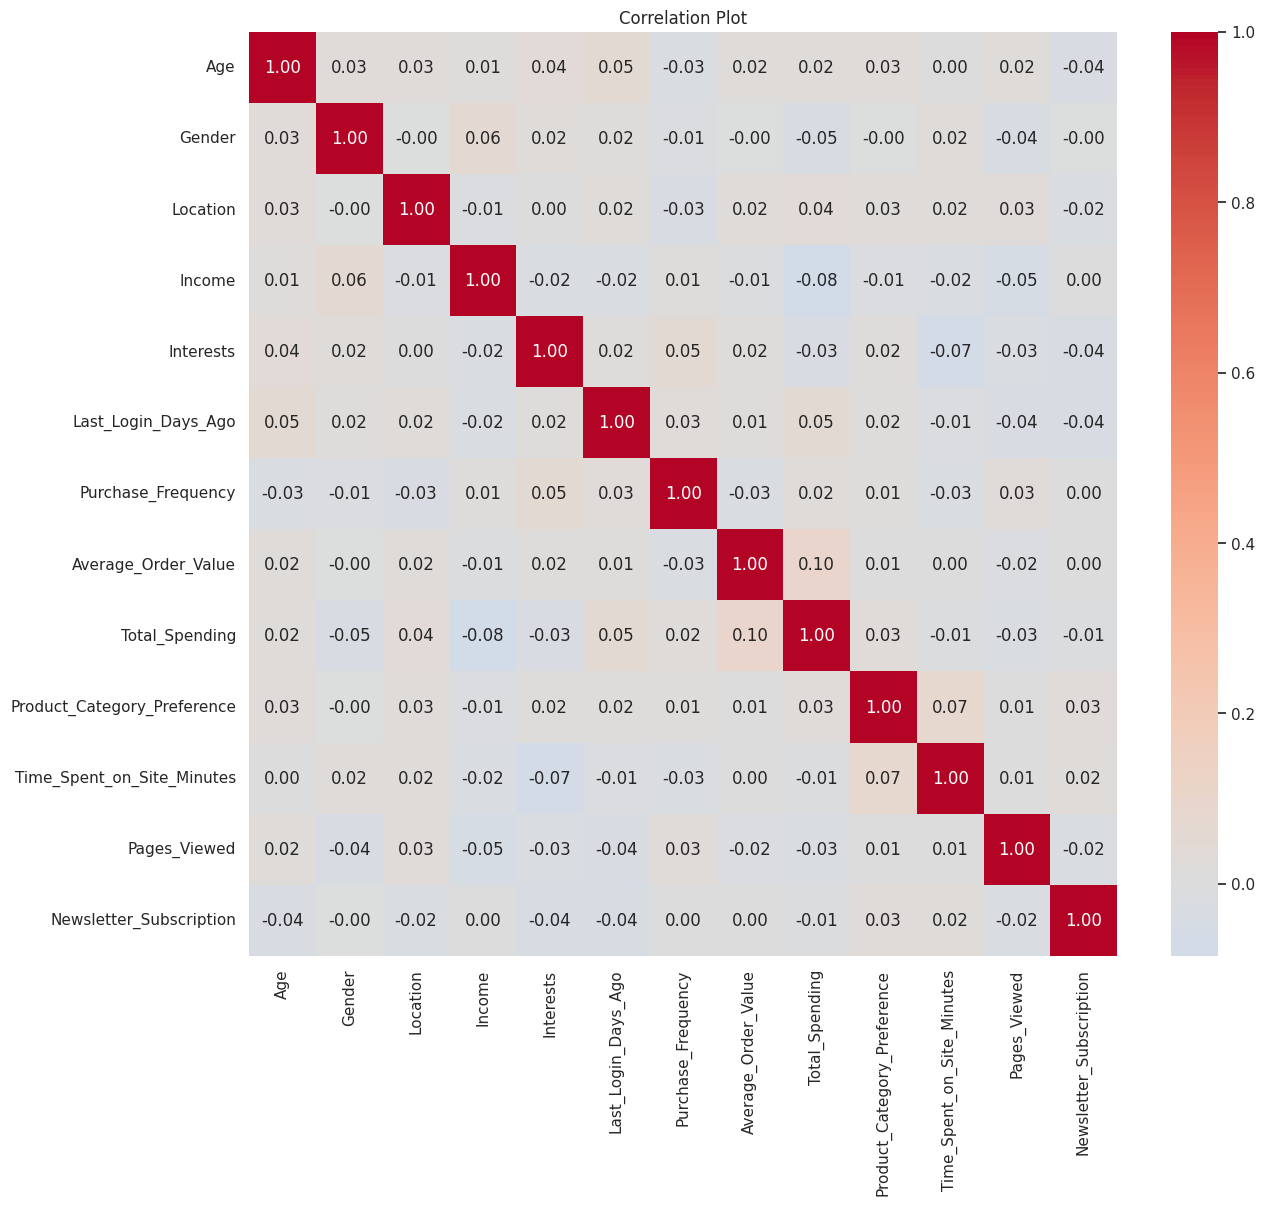

In [153]:
# Calculate correlation matrix
corr_matrix = df_train.corr()

# Plotting correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Plot')
plt.show()

In [154]:
df_train.drop(['Gender', 'Income', 'Purchase_Frequency', 'Average_Order_Value'], inplace = True, axis = 1)

In [155]:
# Engagement Score (a simple combination of time spent and pages viewed)
#df_train['Engagement_Score'] = df_train['Time_Spent_on_Site_Minutes'] * df_train['Pages_Viewed']

In [156]:
# Average Time Per Page
#df_train['Average_Time_Per_Page'] = df_train['Time_Spent_on_Site_Minutes'] / (df_train['Pages_Viewed']+0.000001)

In [157]:
# Spending Per Session (using Pages_Viewed as proxy for sessions)
#df_train['Spending_Per_Session'] = df_train['Total_Spending'] / df_train['Pages_Viewed']

In [158]:
# Spending Per Day Since Last Login
#df_train['Spending_Per_Day_Since_Last_Login'] = df_train['Total_Spending'] / (df_train['Last_Login_Days_Ago']+0.000001)

In [159]:
# Pages Viewed Per Login
#df_train['Pages_Viewed_Per_Login'] = df_train['Pages_Viewed'] / (df_train['Last_Login_Days_Ago']+0.000001)

In [160]:
# Average Spending Per Interest Category
#df_train['Spending_Per_Interest_Category'] = df_train['Total_Spending'] / (df_train['Interests']+0.000001)

In [161]:
# Spending Per Visit
#df_train['Spending_Per_Visit'] = df_train['Total_Spending'] / (df_train['Pages_Viewed']+0.000001)

In [162]:
# Frequent Shopper (arbitrary threshold set at median total spending)
#threshold = df_train['Total_Spending'].median()
#df_train['Frequent_Shopper'] = df_train['Total_Spending'] > threshold

In [163]:
# Define features and target
X = df_train.drop('Newsletter_Subscription', axis=1)
y = df_train['Newsletter_Subscription'].astype('int')

In [164]:
df_train['Newsletter_Subscription'].value_counts()

Newsletter_Subscription
True     507
False    493
Name: count, dtype: int64

Was just checking  for imbalancements!

In [165]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Age'),
  Text(1, 0, 'Location'),
  Text(2, 0, 'Interests'),
  Text(3, 0, 'Last_Login_Days_Ago'),
  Text(4, 0, 'Total_Spending'),
  Text(5, 0, 'Product_Category_Preference'),
  Text(6, 0, 'Time_Spent_on_Site_Minutes'),
  Text(7, 0, 'Pages_Viewed'),
  Text(8, 0, 'Newsletter_Subscription')])

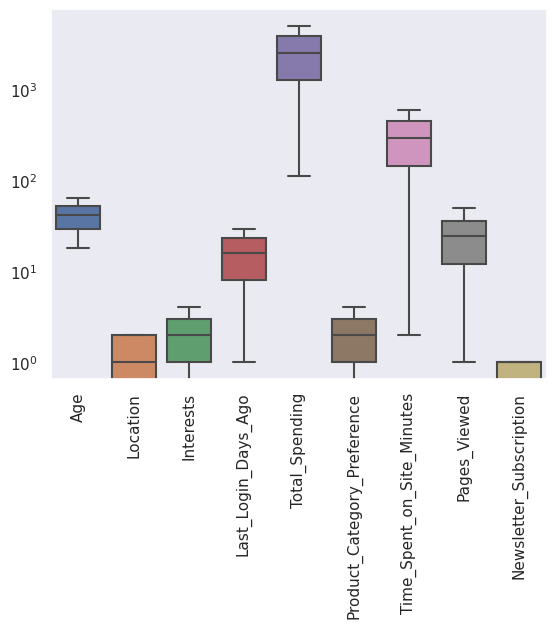

In [166]:
sns.boxplot(df_train)
plt.yscale('log')
plt.xticks(rotation='vertical')

No outliers!

In [167]:
y_train

29     1
535    0
695    0
557    0
836    1
      ..
106    0
270    1
860    0
435    1
102    1
Name: Newsletter_Subscription, Length: 800, dtype: int64

In [168]:
X_train

Age  Location  Interests  Last_Login_Days_Ago  Total_Spending  \
29    44         2          2                    6            2829   
535   38         2          4                    5            4118   
695   45         1          4                   23            2249   
557   47         2          3                   29             736   
836   46         2          4                    1            3357   
..   ...       ...        ...                  ...             ...   
106   52         1          3                   20             980   
270   26         0          2                   29             517   
860   64         1          4                   29             325   
435   26         1          0                   29            4533   
102   28         2          4                    5            1481   

     Product_Category_Preference  Time_Spent_on_Site_Minutes  Pages_Viewed  
29                             1                         509            40  
535                            3                         569            18  
695                            2                         129            48  
557                            0                         561            32  
836                            4                         440            26  
..                           ...                         ...           ...  
106                            0                          94            33  
270                            4                         257            32  
860                            4                          10            29  
435                            3                         240            26  
102                            1                          53            36  

[800 rows x 8 columns]

In [169]:
#columns = ['Age', 'Last_Login_Days_Ago', 'Total_Spending', 'Time_Spent_on_Site_Minutes', 'Pages_Viewed']
#scaler = StandardScaler()
#X_train[columns] = scaler.fit_transform(X_train[columns])
#X_test[columns] = scaler.fit_transform(X_test[columns])

In [170]:
X_train

Age  Location  Interests  Last_Login_Days_Ago  Total_Spending  \
29    44         2          2                    6            2829   
535   38         2          4                    5            4118   
695   45         1          4                   23            2249   
557   47         2          3                   29             736   
836   46         2          4                    1            3357   
..   ...       ...        ...                  ...             ...   
106   52         1          3                   20             980   
270   26         0          2                   29             517   
860   64         1          4                   29             325   
435   26         1          0                   29            4533   
102   28         2          4                    5            1481   

     Product_Category_Preference  Time_Spent_on_Site_Minutes  Pages_Viewed  
29                             1                         509            40  
535                            3                         569            18  
695                            2                         129            48  
557                            0                         561            32  
836                            4                         440            26  
..                           ...                         ...           ...  
106                            0                          94            33  
270                            4                         257            32  
860                            4                          10            29  
435                            3                         240            26  
102                            1                          53            36  

[800 rows x 8 columns]

In [171]:
# Dictionary of classification models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'XGBoost Classifier': XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoostClassifier': CatBoostClassifier(random_seed=42, silent=True)
}

In [172]:
# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'{name}:')
    print(f'  Accuracy: {accuracy:.2f}')
    print(f'  F1 Score: {f1:.2f}\n')
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)  
    print(f"{name} confusion matrix:\n")
    print(conf_matrix)
    print("\n")

Logistic Regression:
  Accuracy: 0.51
  F1 Score: 0.54

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.44      0.48       103
           1       0.50      0.59      0.54        97

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.51       200

Logistic Regression confusion matrix:

[[45 58]
 [40 57]]


Decision Tree:
  Accuracy: 0.54
  F1 Score: 0.54

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.52      0.54       103
           1       0.52      0.56      0.54        97

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200

Decision Tree confusion matrix:

[[54 49]
 [43 54]]


Random Forest:
  Accuracy: 0.53
  F1 Score: 

In [173]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'{name}:')
print(f'  Accuracy: {accuracy:.2f}')
print(f'  F1 Score: {f1:.2f}\n')
print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)  
print(f"{name} confusion matrix:\n")
print(conf_matrix)
print("\n")

CatBoostClassifier:
  Accuracy: 0.60
  F1 Score: 0.63

CatBoostClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.53      0.58       103
           1       0.58      0.68      0.63        97

    accuracy                           0.60       200
   macro avg       0.61      0.61      0.60       200
weighted avg       0.61      0.60      0.60       200

CatBoostClassifier confusion matrix:

[[55 48]
 [31 66]]




The best f1-score i could get is 0.63 and accuarcy 60%. I also got the f1-score of 0.65 but then i noticed my confusion matrix and concluded that my model is predicting all classes as True. That's why final is 0.63 with a valid confusion matrix. Well, i also tried GridSearchCV, didn't got any good result.

# Thank You so much for coming to the end of this notebook!😊